In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string

#from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import text_to_word_sequence
#import tensorflow_hub as hub

In [2]:
print(tf.__version__)

2.1.0


## Preprocessing
#### very simple: keep lower case text only 

In [3]:
rawData = pd.read_csv("data/train.csv")
rawData['wordList'] = rawData['text'].apply(text_to_word_sequence)
target = rawData.target

FileNotFoundError: [Errno 2] File b'data/train.csv' does not exist: b'data/train.csv'

In [102]:
rawData

,id,keyword,location,text,target,wordList
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, wildfires, evacuati..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, a, bridge, colla..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[aria, ahrary, thetawniest, the, out, of, cont..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[police, investigating, after, an, e, bike, co..."


Text(0.5, 1.0, 'tweet lenght distribution')

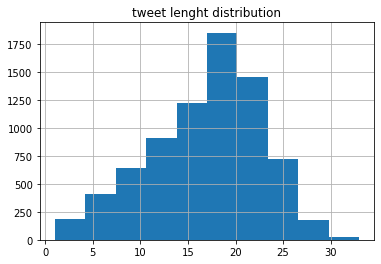

In [260]:
rawData['wordList'].apply(lambda x: len(x)).hist()
plt.title('tweet lenght distribution')

## proto 0: use Gloves as frozen embedding layer

In [262]:
embeddings_dict = {}
with open("data/glove.twitter.27B.25d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

#### for end-to-end optimization, add a embedding layer, preinitialized with Glove
```python 
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
```
where *embedding_matrix* is found from glove data, see https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [263]:
def try_embed(word,gloveSize=25):
    try: 
        vector = embeddings_dict[word]
    except: 
        vector = np.zeros(25)
    return vector 

In [264]:
rawData['vectorList'] = rawData['wordList'].apply(lambda wordList: [try_embed(word) for word in wordList]).apply(np.array)

In [289]:
rawData['vectorList'][0]

array([[-4.2047e-01,  5.6526e-01, -3.3577e-02,  3.1019e-01,  1.8930e-01,
        -6.4588e-01,  1.3876e+00, -5.7484e-01, -1.3896e-01, -3.9003e-01,
        -1.6911e-01, -7.3094e-02, -5.7021e+00,  8.1264e-01, -4.1284e-01,
        -4.3867e-01,  3.6185e-01, -3.4471e-01,  1.4653e-01,  7.6999e-02,
        -1.2756e+00, -6.3190e-01, -6.3516e-01, -5.1729e-01, -9.0167e-01],
       [-4.8785e-01, -6.1645e-02, -4.7218e-01,  1.6183e+00, -6.6795e-01,
        -3.0409e-01,  7.5985e-01, -1.6000e+00,  5.5671e-02, -6.8337e-01,
        -6.9001e-02,  7.3243e-01, -2.1834e+00,  1.3285e+00, -7.9413e-01,
        -5.0598e-01,  1.7160e-01,  6.4233e-01,  1.2438e+00, -2.0530e-01,
         8.6138e-02,  1.0546e+00, -1.2763e+00,  2.8084e-02, -1.6438e-01],
       [ 1.8660e-01, -9.8326e-02, -1.2268e-01, -9.3822e-01, -4.0161e-01,
         6.3830e-01,  1.6686e+00, -6.8036e-01, -9.8359e-01, -7.9512e-02,
         3.8078e-01,  3.9076e-02, -5.4147e+00,  2.8290e-02, -4.7007e-01,
         1.1377e-01, -5.2725e-01, -7.9312e-01,  5

In [269]:
gloveSize = 25

In [270]:
def fullDimMatrix(matrix):
    fullDim = np.zeros((maxTextLength,gloveSize))
    fullDim[0:matrix.shape[0],:] += matrix
    return fullDim

In [267]:
rawData['fullSizeVectorMatrix'] = rawData['vectorList'].apply(lambda matrix :np.asarray(fullDimMatrix(matrix)))

In [294]:
rawData

,id,keyword,location,text,target,wordList,vectorList,fullSizeVectorMatrix
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth...","[[-0.42047, 0.56526, -0.033577, 0.31019, 0.189...","[[-0.4204699993133545, 0.5652599930763245, -0...."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[[-1.2358, -0.58127, 0.20145, 0.01657, -1.3504...","[[-1.23580002784729, -0.5812699794769287, 0.20..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[[-0.1823199987411499, 0.9699699878692627, 0.3...","[[-0.1823199987411499, 0.9699699878692627, 0.3..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, wildfires, evacuati...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[[-0.35518, 0.4803, 0.49681, -0.76379, -0.6458...","[[-0.3551799952983856, 0.48030000925064087, 0...."
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, a, bridge, colla...","[[0.5829600095748901, 0.44516998529434204, 1.0...","[[0.5829600095748901, 0.44516998529434204, 1.0..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[aria, ahrary, thetawniest, the, out, of, cont...","[[-1.1461000442504883, -0.18153999745845795, 0...","[[-1.1461000442504883, -0.18153999745845795, 0..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[police, investigating, after, an, e, bike, co...","[[0.30003, 0.34859, -0.2896, -0.30224, -0.5052...","[[0.300029993057251, 0.3485899865627289, -0.28..."


In [ ]:
# 

### parameters

In [250]:
batch_size = 128
epochs = 10

n_filters = 10
kernel_size = 5

In [272]:
df_train, df_dev, y_train, y_dev = train_test_split(rawData, target, test_size=0.33)

y_train = np.asarray(y_train).astype('float32')
y_dev = np.asarray(y_dev).astype('float32')

In [296]:
# as tf.dataset
train_ds = tf.data.Dataset.from_tensor_slices((df_train['vectorList'].values,y_train))
dev_ds = tf.data.Dataset.from_tensor_slices((df_dev['vectorList'],y_dev))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [276]:

embedded_sequences = layers.Input(shape = (None,gloveSize) ,ragged=True)

#swivel = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], 
#                           dtype=tf.string, trainable=True)

conv1 = layers.Conv1D(n_filters, kernel_size)(embedded_sequences) #  activation='relu'?
maxPool1  = layers.MaxPooling1D()(conv1)
flatten = layers.Flatten()(maxPool1)
preds = layers.Dense(2, activation='softmax')(flatten)
# OR preds = layers.Dense(1, activation='sigmoid')


In [277]:
model = keras.Model(embedded_sequences, preds)
model.compile(loss='categorical_crossentropy',metrics=['acc'])

In [279]:
model.fit(train_ds, validation_data=dev_ds,
          epochs=epochs)

ValueError: in converted code:

    /home/rasoluci/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/rasoluci/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home/rasoluci/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected input_5 to have 3 dimensions, but got array with shape (33, 25)
